Inspired by [this example](https://github.com/denisa-ms/azure-openai-code-samples/blob/main/GPT4o/Use%20GPT4o%20with%20images.ipynb) from [Denise Schlesinger](https://github.com/denisa-ms), This Jupyter notebook demonstrates the use of AzureOpenAI's GPT-4o model to generate a comprehensive natural language description of a car.

### **Load Environment variables from .env file**

In [4]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
from IPython.display import display, HTML, JSON, Markdown, Image
import requests

load_dotenv()

AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_API_ENDPOINT = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_MODEL = os.getenv("AZURE_OPENAI_API_MODEL")
DVLA_API_KEY = os.getenv("DVLA_API_KEY")

client = AzureOpenAI(
  azure_endpoint = AZURE_OPENAI_API_ENDPOINT, 
  api_key=AZURE_OPENAI_API_KEY,  
  api_version="2024-02-01"
)

In [5]:
def call_openAI(text):
    response = client.chat.completions.create(
        model=AZURE_OPENAI_API_MODEL,
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

### **Image input**  
Load image and show preview

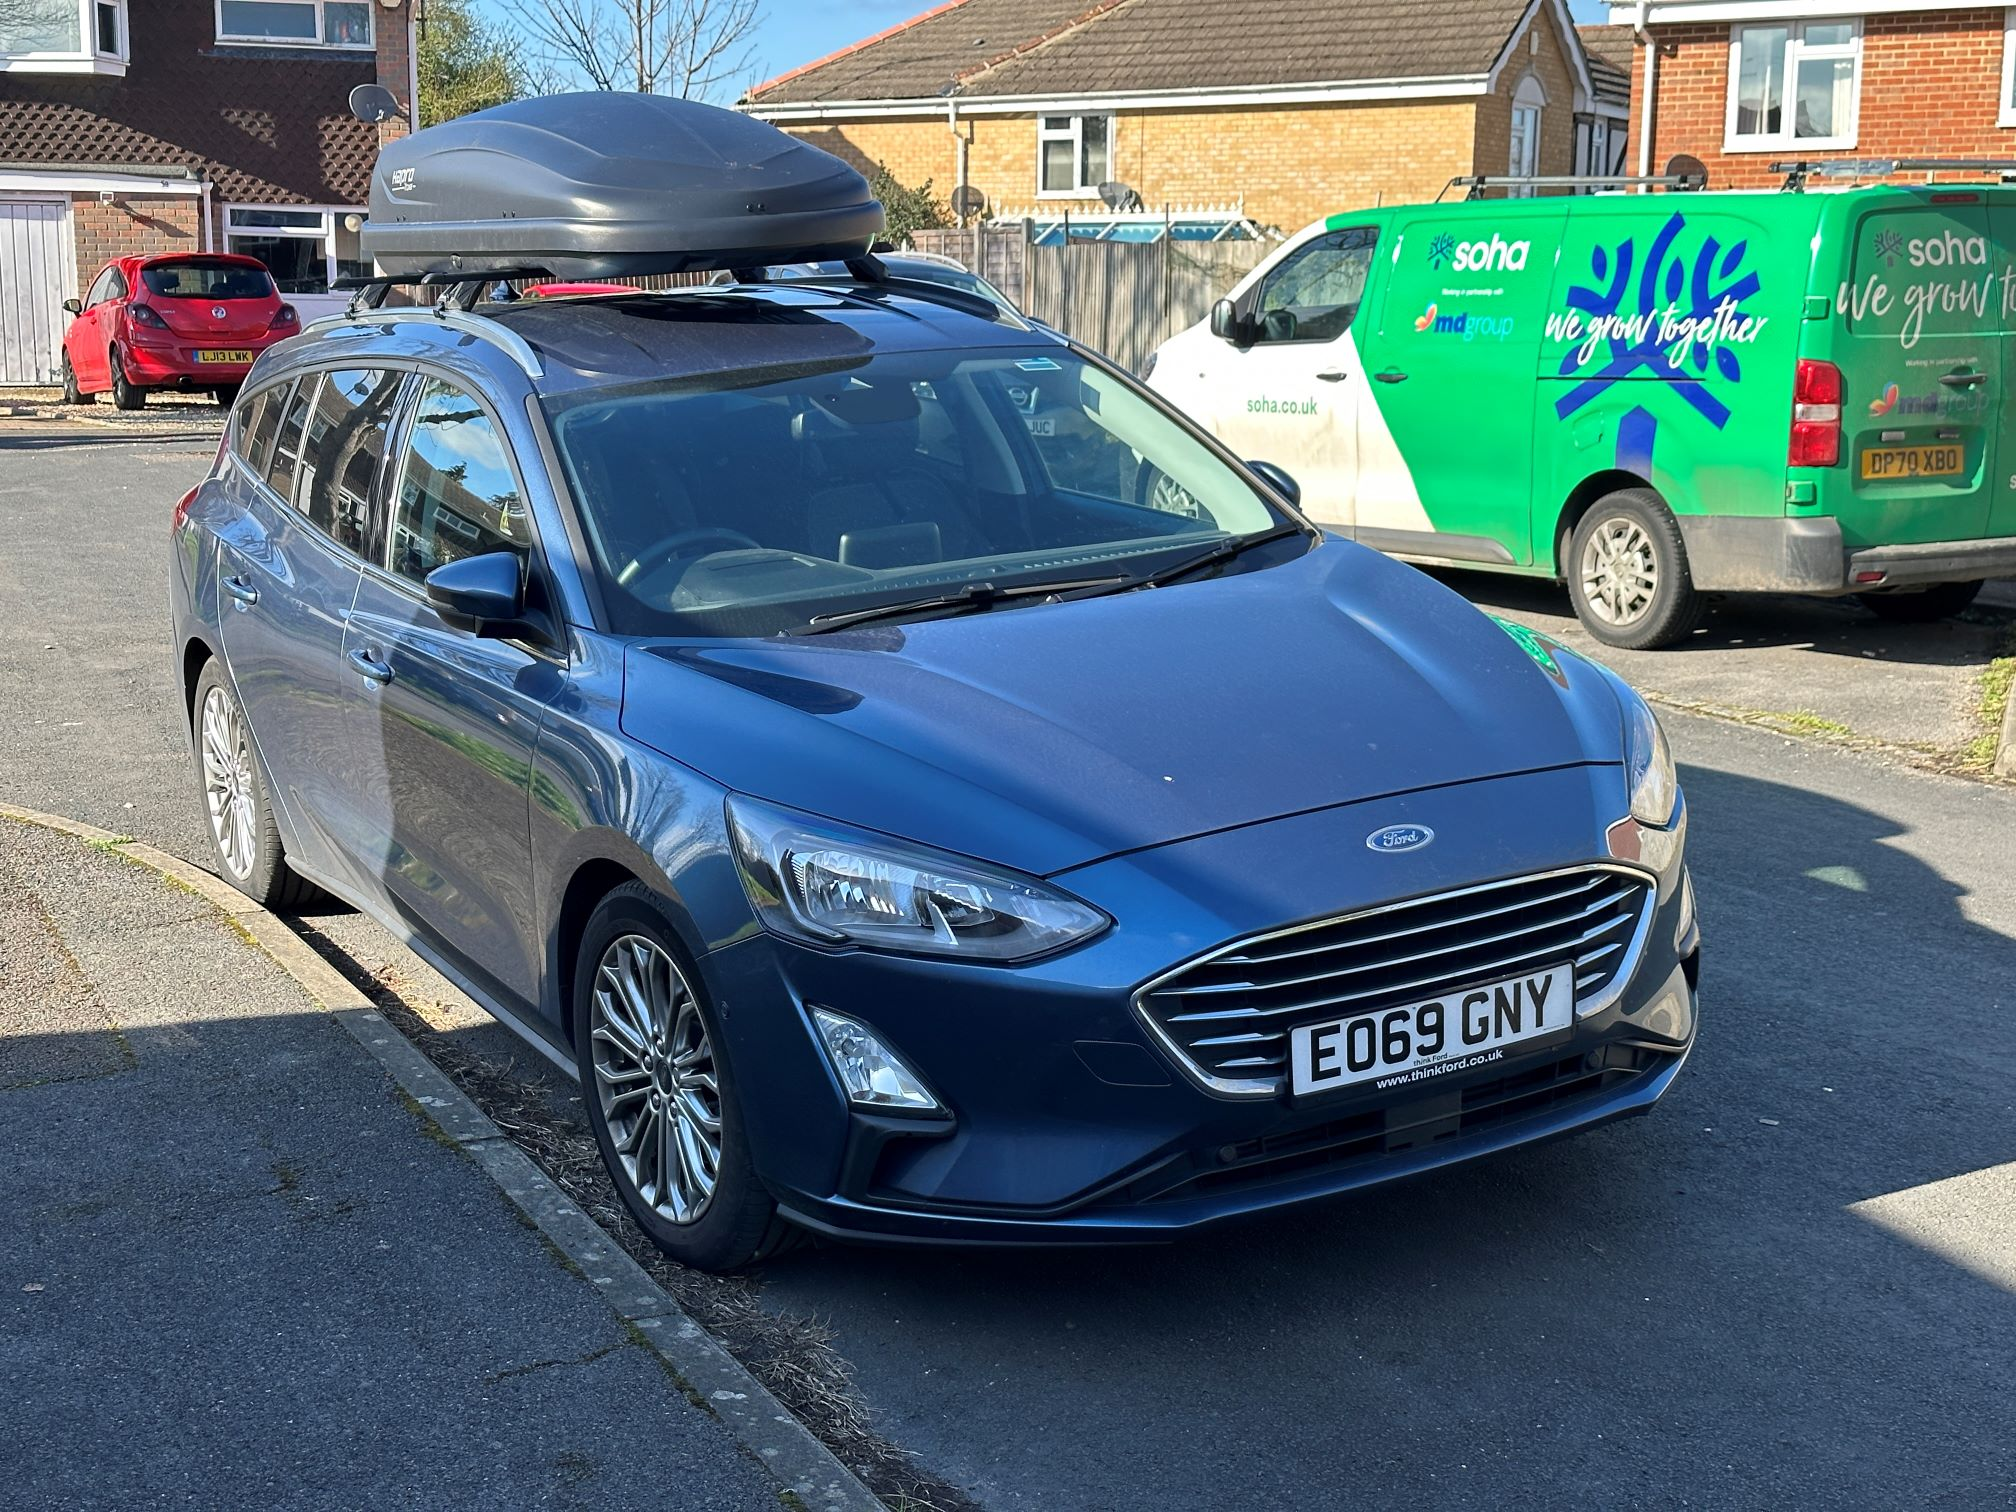

In [6]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

IMAGE_PATH = "./data/Car.jpg"
base64_image = encode_image(IMAGE_PATH)
# Preview image for context
display(Image(IMAGE_PATH))

### **Summarise the car description**  
Use GPT-4o to return a JSON object, using JSON mode

In [7]:
import json

def call_openAI_JSON(text):
    response = client.chat.completions.create(
        model=AZURE_OPENAI_API_MODEL,
        response_format={ "type": "json_object" },
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

messages=[
    {"role": "system", "content": "You are a helpful assistant that explains the car in the image to the user. Output a JSON object."},
    {"role": "user", "content": [
        {"type": "text", "text": "What is the make, model, colour, registration, body_type, features"},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]}
]

resultCar = call_openAI_JSON(messages)
display(HTML(resultCar))
resultCar_json = json.loads(resultCar)
registrationPlate = resultCar_json["registration"]
display(HTML(registrationPlate))



### **Query the DVLA database via API**  
Let's fetch the details of the car from the DVLA using the registration plate

In [8]:
url = "https://driver-vehicle-licensing.api.gov.uk/vehicle-enquiry/v1/vehicles"

payload = f'{{\n\t"registrationNumber": "{registrationPlate}"\n}}'
headers = {
  'x-api-key': DVLA_API_KEY,
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data = payload)

display(response.text.encode('utf8'))

b'{"registrationNumber":"EO69GNY","taxStatus":"Taxed","taxDueDate":"2025-07-01","motStatus":"Valid","make":"FORD","yearOfManufacture":2019,"engineCapacity":1496,"co2Emissions":125,"fuelType":"PETROL","markedForExport":false,"colour":"BLUE","typeApproval":"M1","revenueWeight":1950,"euroStatus":"EURO 6 DG","dateOfLastV5CIssued":"2020-07-20","motExpiryDate":"2024-09-04","wheelplan":"2 AXLE RIGID BODY","monthOfFirstRegistration":"2019-09"}'

### **Provide a natural language summary**  
Using both the information from the DVLA and the description from the image, summarise the vehicle using GPT-4o

In [9]:
messages=[
    {"role": "system", "content": "You are a helpful assistant that provides a comprehensive natural language description of a car. Read all the information, merge it together, and then provide a clear description to the user."},
    {"role": "user", "content": [
        {"type": "text", "text": f"{resultCar}"f"{response.text}"},
    ]}
]

description = call_openAI(messages)
display(HTML(description))



### **Write the copy for an advert**  
Use GPT-4o to write a description to sell the car

In [7]:
messages=[
    {"role": "system", "content": "You are a helpful assistant that writes the job advert for a car showroom. Read all the information, merge it together, and then provide a few paragraphs of descriptive sales text to be included for the car advert. Don't mention the car's registration plate."},
    {"role": "user", "content": [
        {"type": "text", "text": f"{resultCar}"f"{response.text}"},
    ]}
]

description = call_openAI(messages)
display(HTML(description))

